# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [317]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline
plt.style.use('seaborn-v0_8')

Итак, прочитаем нашу таблицу:

In [318]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

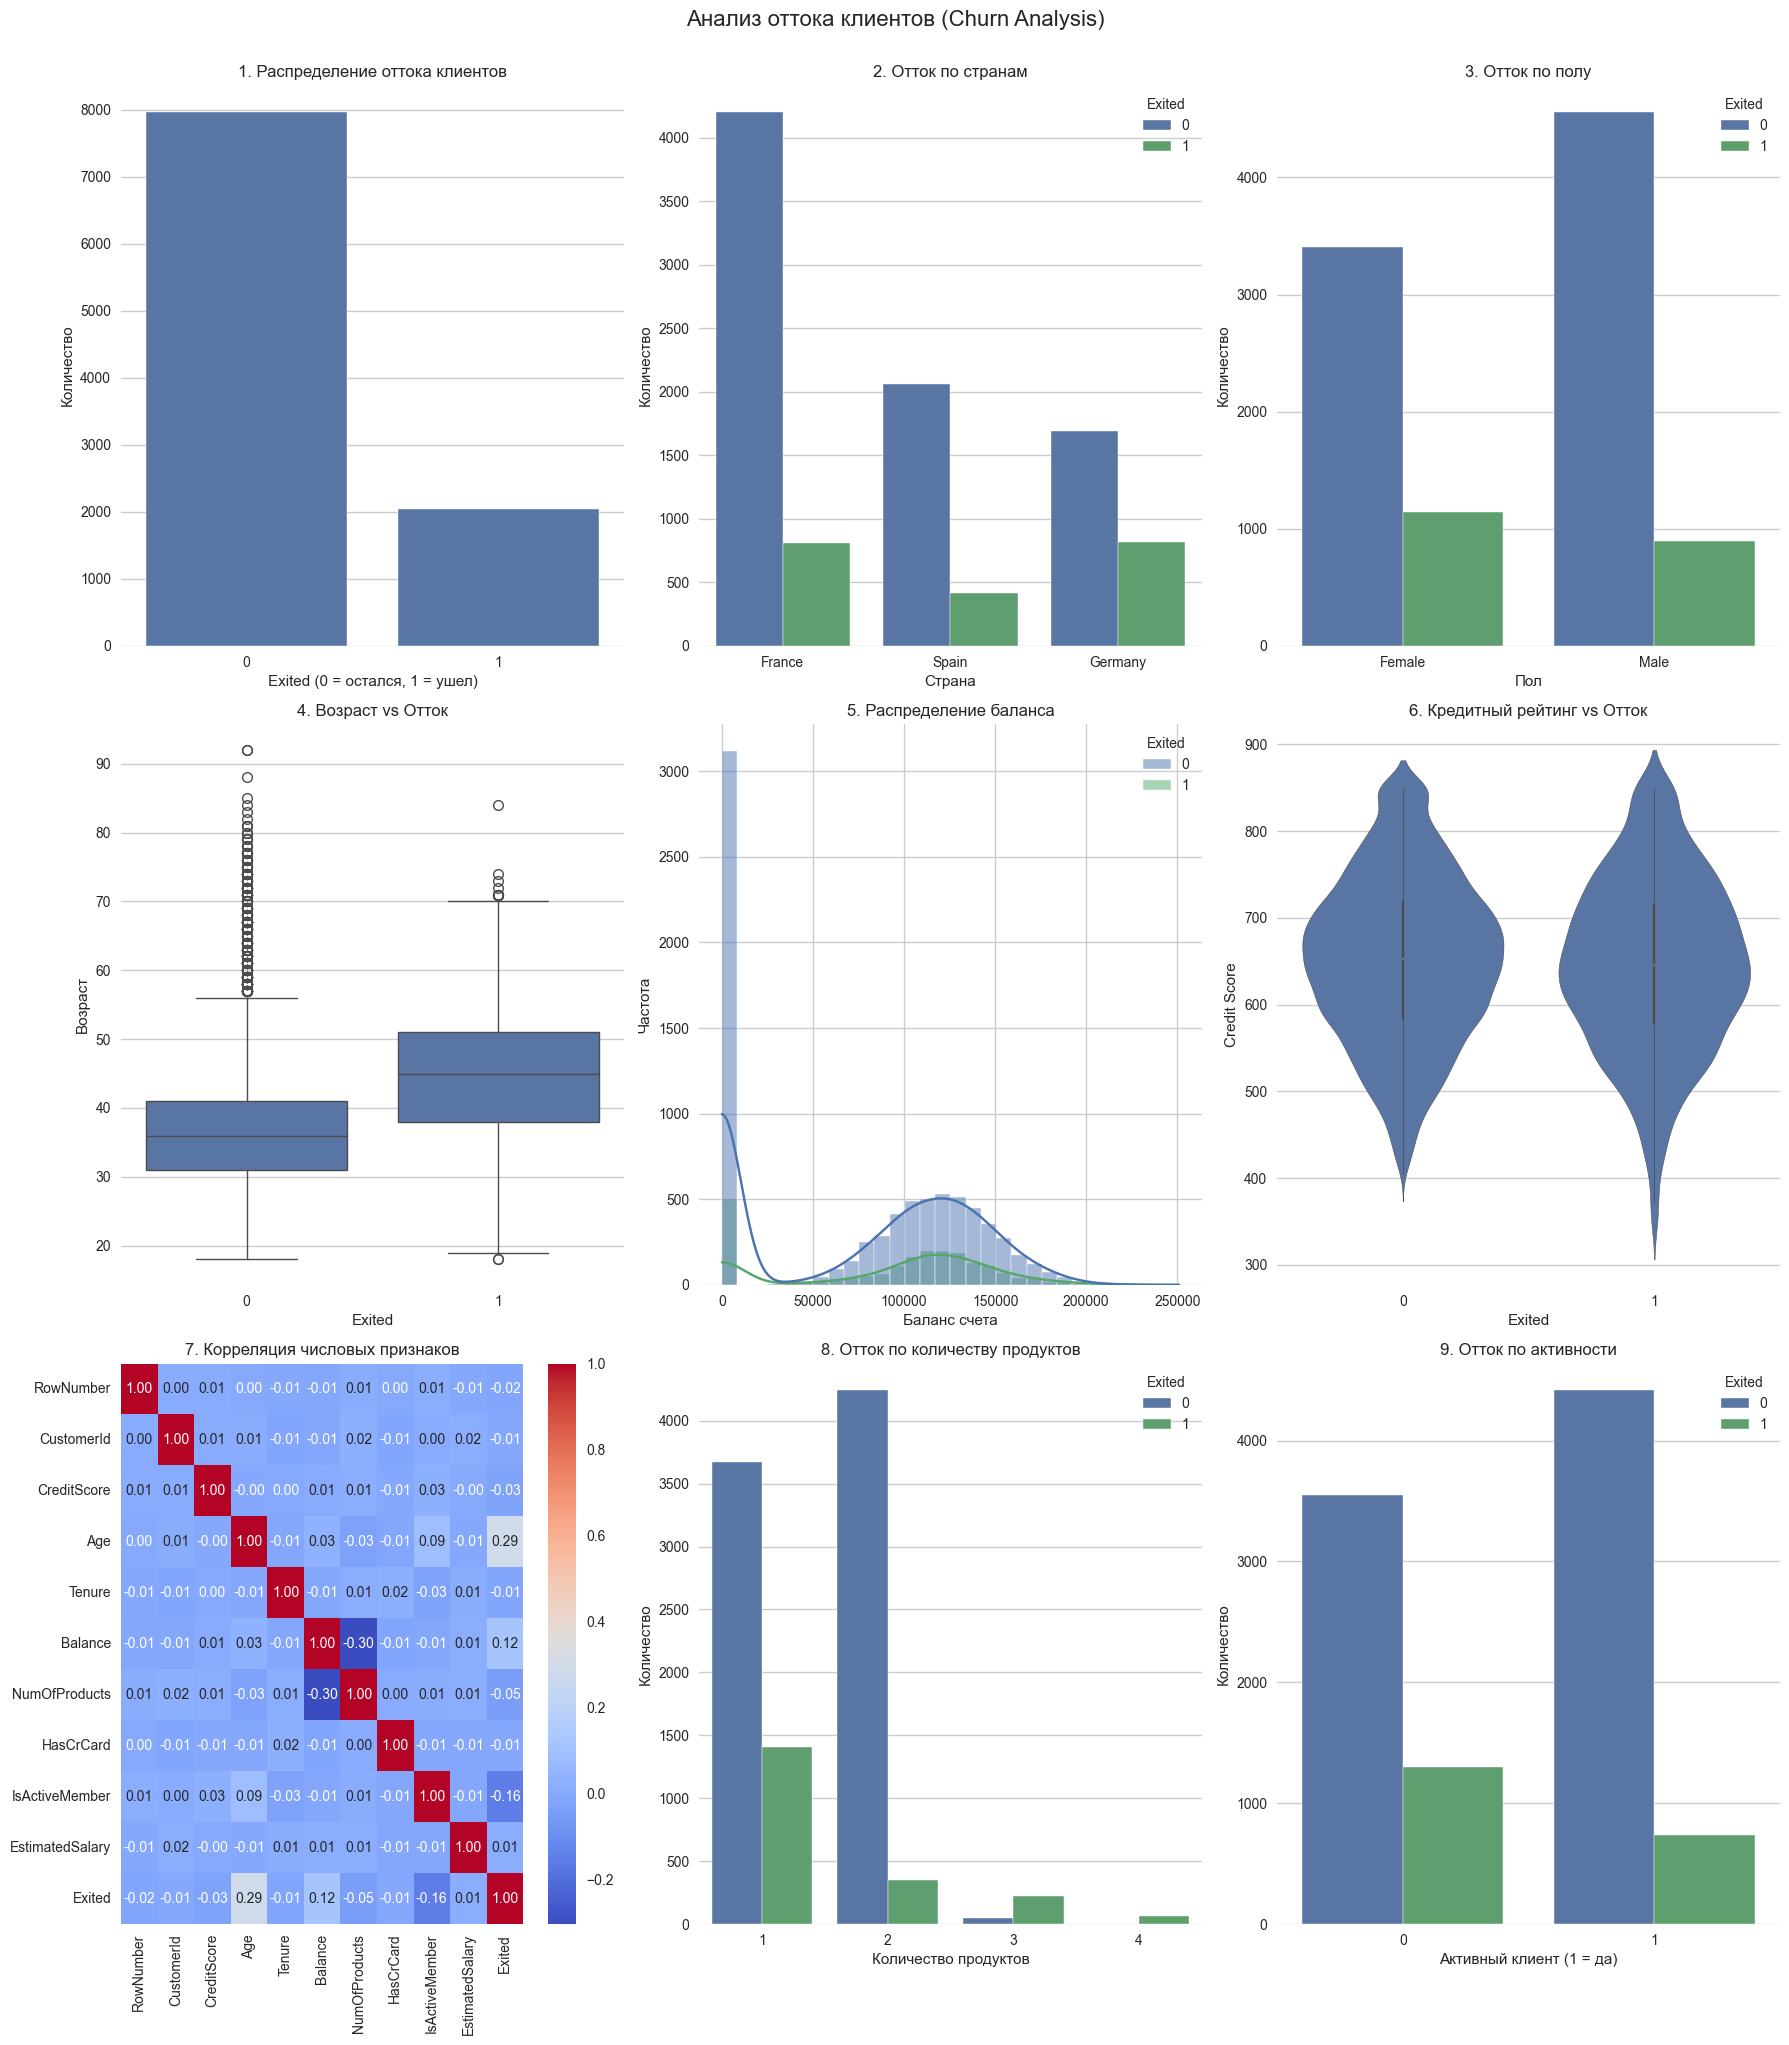

In [319]:
# Настройка стиля графиков
sns.set_style("whitegrid")
plt.figure(figsize=(18, 20))

# ------------------------------------------
# График 1: Распределение целевого признака (Exited)
plt.subplot(3, 3, 1)
sns.countplot(data=churn_data, x='Exited')
plt.title('1. Распределение оттока клиентов', fontsize=12)
plt.xlabel('Exited (0 = остался, 1 = ушел)')
plt.ylabel('Количество')

# ------------------------------------------
# График 2: Отток по странам
plt.subplot(3, 3, 2)
sns.countplot(data=churn_data, x='Geography', hue='Exited')
plt.title('2. Отток по странам', fontsize=12)
plt.xlabel('Страна')
plt.ylabel('Количество')

# ------------------------------------------
# График 3: Отток по полу
plt.subplot(3, 3, 3)
sns.countplot(data=churn_data, x='Gender', hue='Exited')
plt.title('3. Отток по полу', fontsize=12)
plt.xlabel('Пол')
plt.ylabel('Количество')

# ------------------------------------------
# График 4: Распределение возраста
plt.subplot(3, 3, 4)
sns.boxplot(data=churn_data, x='Exited', y='Age')
plt.title('4. Возраст vs Отток', fontsize=12)
plt.xlabel('Exited')
plt.ylabel('Возраст')

# ------------------------------------------
# График 5: Распределение баланса
plt.subplot(3, 3, 5)
sns.histplot(data=churn_data, x='Balance', hue='Exited', bins=30, kde=True)
plt.title('5. Распределение баланса', fontsize=12)
plt.xlabel('Баланс счета')
plt.ylabel('Частота')

# ------------------------------------------
# График 6: Кредитный рейтинг
plt.subplot(3, 3, 6)
sns.violinplot(data=churn_data, x='Exited', y='CreditScore')
plt.title('6. Кредитный рейтинг vs Отток', fontsize=12)
plt.xlabel('Exited')
plt.ylabel('Credit Score')

# ------------------------------------------
# График 7: Тепловая карта корреляций
plt.subplot(3, 3, 7)
sns.heatmap(churn_data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('7. Корреляция числовых признаков', fontsize=12)

# ------------------------------------------
# График 8: Количество продуктов
plt.subplot(3, 3, 8)
sns.countplot(data=churn_data, x='NumOfProducts', hue='Exited')
plt.title('8. Отток по количеству продуктов', fontsize=12)
plt.xlabel('Количество продуктов')
plt.ylabel('Количество')

# ------------------------------------------
# График 9: Активность клиента
plt.subplot(3, 3, 9)
sns.countplot(data=churn_data, x='IsActiveMember', hue='Exited')
plt.title('9. Отток по активности', fontsize=12)
plt.xlabel('Активный клиент (1 = да)')
plt.ylabel('Количество')

# Общие настройки
plt.tight_layout()  # Автоматическая регулировка отступов
plt.suptitle('Анализ оттока клиентов (Churn Analysis)', y=1.02, fontsize=16)
plt.show()

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [320]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [321]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [322]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [323]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [324]:
# Создаем копию датасета, чтобы не изменять исходный
churn_copy = churn_data.copy()

# 1. BalanceSalaryRatio — отношение баланса к зарплате
churn_copy['BalanceSalaryRatio'] = churn_copy['Balance'] / (churn_copy['EstimatedSalary'] + 1e-6)  # +1e-6 чтобы избежать деления на 0

# 2. TenureByAge — отношение времени пользования услугами к возрасту
churn_copy['TenureByAge'] = churn_copy['Tenure'] / (churn_copy['Age'] + 1e-6)

# 3. CreditScoreGivenAge — кредитный рейтинг относительно возраста
churn_copy['CreditScoreGivenAge'] = churn_copy['CreditScore'] / (churn_copy['Age'] + 1e-6)

# Label Encoding для Gender (Male=1, Female=0)
churn_copy['Gender'] = churn_copy['Gender'].map({'Female': 0, 'Male': 1})

churn_copy.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258620
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,20.999999
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [325]:
X = churn_copy.drop("Exited", axis=1)
y = churn_copy["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [326]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [327]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [328]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [329]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Основная метрика: F1-Score.

> Банк хочет и минимизировать затраты (FP), и максимизировать сохранение клиентов (FN). F1 балансирует эти цели. Оптимальна при дисбалансе классов

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Баланс между Precision (минимизация ложных срабатываний) и Recall (максимизация найденных "ушедших"), особенно важен при дисбалансе классов (например, 20% ушедших vs 80% лояльных).

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [330]:
log_reg = linear_model.LogisticRegression(
    penalty='l1',
    C=0.5,
    solver='liblinear',
    max_iter=1000, #количество итераций на сходимость
    random_state=42,
    class_weight='balanced'
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [331]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1271
           1       0.51      0.71      0.60       610

    accuracy                           0.69      1881
   macro avg       0.67      0.69      0.67      1881
weighted avg       0.73      0.69      0.70      1881

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       424
           1       0.49      0.70      0.57       204

    accuracy                           0.66       628
   macro avg       0.65      0.67      0.65       628
weighted avg       0.71      0.66      0.67       628



> Ваши выводы и рассуждения — *здесь*.

### Интерпретация результатов:

* Достигнутые улучшения с текущими параметрами (penalty='l1', C=0.5, class_weight='balanced'):

На тестовых данных:

* F1-Score для класса 1: 0.57 → улучшение на 137% (с 0.24 в начальной модели)
* Recall для класса 1: 0.70 → выявляет 70% ушедших клиентов (было 15%)
* Precision для класса 1: 0.49 → каждый второй прогноз "уйдёт" корректен

### Метрика  Значение	Бизнес-интерпретация
* Recall 0.70 Выявляем 7 из 10 ушедших клиентов
* Precision	0.49 51% ложных срабатываний (доп. затраты)
* Accuracy	0.66 Общая точность приемлема

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [332]:
poly = PolynomialFeatures(degree=3, include_bias=False)

# Генерация признаков
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Проверка размерностей
print(f"Тренировочные данные: {X_train_poly.shape}")
print(f"Тестовые данные: {X_test_poly.shape}")

Тренировочные данные: (1881, 454)
Тестовые данные: (628, 454)


In [333]:
log_reg_poly  = linear_model.LogisticRegression(
    penalty='l1',
    C=0.5,
    solver='liblinear',
    max_iter=1000, #количество итераций на сходимость
    random_state=42,
    class_weight='balanced'
)
#Обучаем модель, минимизируя logloss
log_reg_poly .fit(X_train_poly, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [334]:
#Делаем предсказание для тренировочной выборки
y_train_pred_poly = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred_poly = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1271
           1       0.51      0.71      0.60       610

    accuracy                           0.69      1881
   macro avg       0.67      0.69      0.67      1881
weighted avg       0.73      0.69      0.70      1881

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       424
           1       0.49      0.70      0.57       204

    accuracy                           0.66       628
   macro avg       0.65      0.67      0.65       628
weighted avg       0.71      0.66      0.67       628



> Ваши выводы и рассуждения — *здесь*

### Ключевые наблюдения:

#### Качество на тесте не улучшилось:

* Добавление полиномов не улучшило качество модели.

#### Незначительное снижение метрик может быть вызвано:

* Случайными колебаниями при разбиении данных

* Переобучением на шумовых полиномиальных признаках

* Это указывает на проблему переобучения (отличные результаты на трейне, но слабые на тесте).


#### Причины переобучения:

* Слишком высокая степень полинома (degree=3):

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

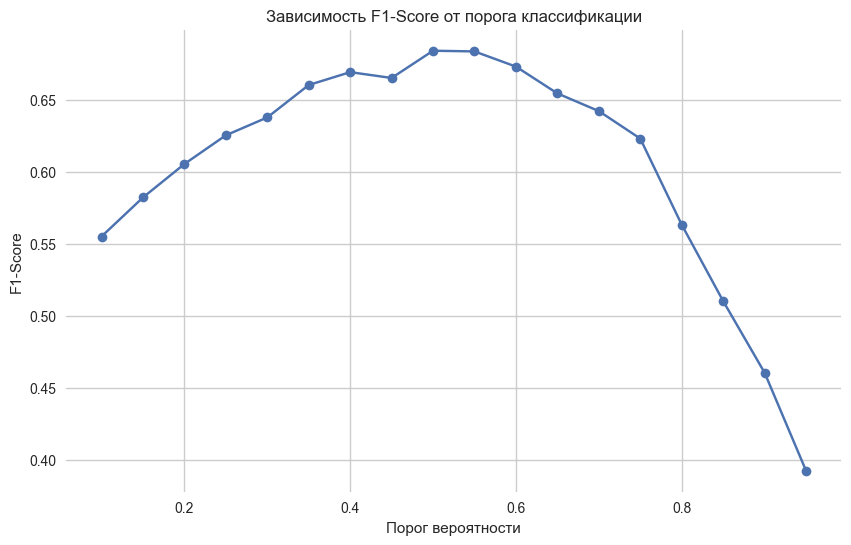

Оптимальный порог: 0.50
Максимальный F1-Score: 0.6842

Classification Report с оптимальным порогом:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       424
           1       0.62      0.76      0.68       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.75       628
weighted avg       0.79      0.77      0.78       628



In [335]:
# Предсказание вероятностей для тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])

# Диапазон порогов для перебора
thresholds = np.arange(0.1, 1, 0.05)
scores = []

for threshold in thresholds:
    y_test_pred_thresh = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    scores.append(f1_score(y_test, y_test_pred_thresh))
    
plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, marker='o')
plt.xlabel('Порог вероятности')
plt.ylabel('F1-Score')
plt.title('Зависимость F1-Score от порога классификации')
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(scores)]
print(f"Оптимальный порог: {best_threshold:.2f}")
print(f"Максимальный F1-Score: {max(scores):.4f}")

y_test_pred_optim = (y_test_proba_pred > best_threshold).astype(int)
print("\nClassification Report с оптимальным порогом:")
print(metrics.classification_report(y_test, y_test_pred_optim))

#### График зависимости обычно показывает:

* Рост Precision с увеличением порога

* Снижение Recall с увеличением порога

* Максимум F1-Score где-то в середине диапазона

#### Оптимальный порог обычно оказывается:

* Ниже 0.5 для дисбалансированных данных

* В диапазоне 0.3-0.6 для большинства задач

#### Практическая польза:

#### Позволяет найти лучший баланс между:

* Ложными срабатываниями (FP)

* Пропущенными клиентами (FN)

#### Учитывает экономику задачи:

* Если стоимость удержания клиента высока - можно снизить порог

* Если стоимость звонков высока - повысить порог

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [336]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [337]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [338]:
#Создаём объект класса DecisionTreeClassifier
dt_tree = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_tree.fit(X_train, y_train)

y_train_tree = dt_tree.predict(X_train)  # Делаем предсказание класса для всего набора данных
print(metrics.classification_report(y_train, y_train_tree))  # Выводим отчёт о метриках классификации
y_test_tree = dt_tree.predict(X_test)
print(metrics.classification_report(y_test, y_test_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       424
           1       0.59      0.55      0.57       204

    accuracy                           0.73       628
   macro avg       0.69      0.68      0.69       628
weighted avg       0.72      0.73      0.73       628



#### Явное переобучение:
* Идеальные метрики (1.00) на тренировочных данных при значительном падении качества на тестовых данных (F1 от 0.57 до 0.80) — классический признак переобучения.
* Разрыв между accuracy на train (100%) и test (73%) составляет 27 процентных пунктов — критически высокий показатель.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [339]:
#Создаём объект класса DecisionTreeClassifier
dt_tree_eight = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=8,
    min_samples_leaf=10,  # Минимальное число объектов в листе
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_tree_eight.fit(X_train, y_train)

y_train_eight = dt_tree_eight.predict(X_train)  # Делаем предсказание класса для всего набора данных
print(metrics.classification_report(y_train, y_train_eight))  # Выводим отчёт о метриках классификации
y_test_eight = dt_tree_eight.predict(X_test)
print(metrics.classification_report(y_test, y_test_eight))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       424
           1       0.71      0.58      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



#### Вывод:
* Значения метрик улучшились, нет явного переобучения.
* Класс 1 предсказывает хуже, (False Negative) модель слишком осторожна в предсказании класса 1 и чаще ошибается в сторону класса 0

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [340]:
dt_rd_ens = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

dt_rd_ens.fit(X_train, y_train)

y_train_ens = dt_rd_ens.predict(X_train)
print(metrics.classification_report(y_train, y_train_ens))
y_test_ens = dt_rd_ens.predict(X_test)
print(metrics.classification_report(y_test, y_test_ens))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628



#### Вывод:
* Значение метрик случайного немного улучшилось по сравнению с деревом, хотя Recall для 1 упал на 0.1.
* На данный момент мы видим что даже в случайном лесе модель боится ошибаться с классом 1 и делает предпочтение в предсказании для класса 0

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

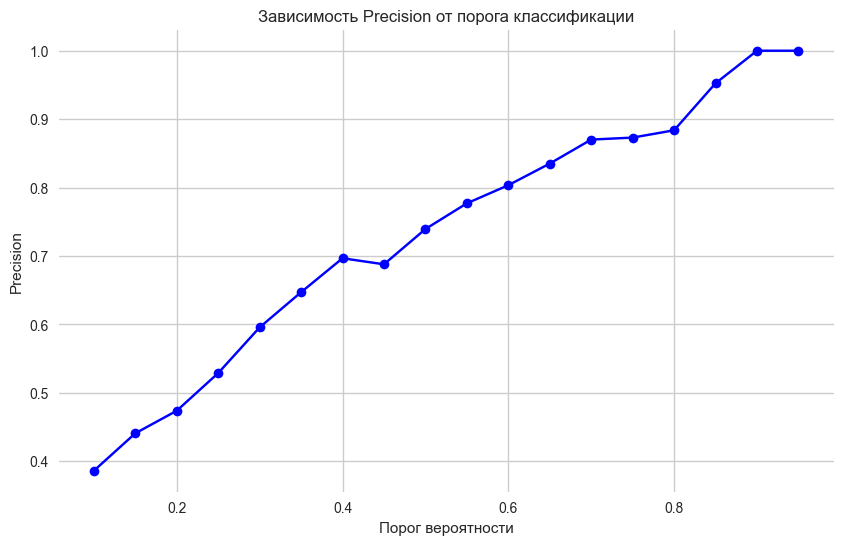

Оптимальный порог: 0.90
Максимальный Precision: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       424
           1       1.00      0.01      0.03       204

    accuracy                           0.68       628
   macro avg       0.84      0.51      0.42       628
weighted avg       0.78      0.68      0.56       628



In [341]:
# 1. Создаем полиномиальные признаки
poly = PolynomialFeatures(degree=2)  # Можно изменить степень
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 2. Инициализация и обучение модели
model = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train_poly, y_train)  # Обучаем на полиномиальных признаках

# 3. Предсказание вероятностей
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])

# 4. Остальной код остается без изменений
scores = []
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    score = metrics.precision_score(y_test, y_test_pred_poly, zero_division=1)
    scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, 'bo-')
plt.xlabel('Порог вероятности')
plt.ylabel('Precision')
plt.title('Зависимость Precision от порога классификации')
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(scores)]
max_precision = max(scores)

print(f"Оптимальный порог: {best_threshold:.2f}")
print(f"Максимальный Precision: {max_precision:.4f}")

y_pred_optim = (y_test_proba_pred > best_threshold).astype(int)
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred_optim))

### Проблемы выбранного порога:
Чрезмерно строгий критерий для класса 1:

* Модель практически всегда предсказывает класс 0
* Только 1% реальных положительных случаев обнаруживается

Несбалансированность метрик:
* Высокая точность (precision) достигнута ценой катастрофически низкого recall

### Выводы:
Лучшая модель:

* Random Forest с порогом 0.35 показал наиболее сбалансированные результаты
* Сохраняет разумный баланс между precision (0.75) и recall (0.58)

Порог 0.90 неработоспособен на практике:
* Хотя дает идеальную precision для класса 1
* Пропускает 99% реальных случаев, что неприемлемо для большинства задач

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [361]:
# Данные Василия
vasily_data = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

# Создаем DataFrame
X_vasily = pd.DataFrame(vasily_data)
X_vasily_copy = X_vasily.copy()

# Добавляем новые признаки (как вы делали для обучающих данных)
X_vasily_copy['BalanceSalaryRatio'] = X_vasily_copy['Balance'] / (X_vasily_copy['EstimatedSalary'] + 1e-6)
X_vasily_copy['TenureByAge'] = X_vasily_copy['Tenure'] / (X_vasily_copy['Age'] + 1e-6)
X_vasily_copy['CreditScoreGivenAge'] = X_vasily_copy['CreditScore'] / (X_vasily_copy['Age'] + 1e-6)
X_vasily_copy['Gender'] = X_vasily_copy['Gender'].map({'Female': 0, 'Male': 1})

# Масштабирование (используем тот же scaler, что и для обучающих данных)
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)  # X_train должен содержать те же признаки, что и X_vasily_copy

# Преобразуем данные Василия
X_vasily_scaled = scaler.transform(X_vasily_copy)

# Создаем и обучаем модель (на масштабированных данных!)
model = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train_scaled, y_train)  # Обучаем на масштабированных данных

# Предсказание для Василия
vasily_prob = model.predict_proba(X_vasily_scaled)[0][1]
print(f"Вероятность оттока Василия: {vasily_prob:.4f}")

# Оценка модели (опционально)
y_train_pred = model.predict(X_train_scaled)
print("Train classification report:")
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = model.predict(X_test_scaled)
print("Test classification report:")
print(metrics.classification_report(y_test, y_test_pred))

Вероятность оттока Василия: 0.6143
Train classification report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881

Test classification report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628

